# Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


## Import library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif

# Data Understanding

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Rakamin Academy X IDX Partners/loan_data_2007_2014.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [ ]:
# prompt: generate daftar colom yang merupakan all null

# Identify columns with all null values
all_null_columns = data.columns[data.isnull().all()]

# Print the list of columns
print("Columns with all null values:")
print(all_null_columns.tolist())


Columns with all null values:
['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']


there is several column that will be dropped

In [ ]:
#Define the columns we will drop

cols_to_drop = [
    #unique_id
    'Unnamed: 0',
    'id',
    'member_id',

    #free_text
    'url',
    'desc',
    'zip_code',
    'title',
    #'emp_title' -> we will use it on EDA first then drop it before modelling

    #all null
    'annual_inc_joint',
    'dti_joint',
    'verification_status_joint',
    'open_acc_6m',
    'open_il_6m',
    'open_il_12m',
    'open_il_24m',
    'mths_since_rcnt_il',
    'total_bal_il',
    'il_util',
    'open_rv_12m',
    'open_rv_24m',
    'max_bal_bc',
    'all_util',
    'inq_fi',
    'total_cu_tl',
    'inq_last_12m',

    #drop unused data

]

In [ ]:
# dropping the columns in col_to_drop
data.drop(cols_to_drop, axis=1, inplace=True)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 51 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    466285 non-null  int64  
 1   funded_amnt                  466285 non-null  int64  
 2   funded_amnt_inv              466285 non-null  float64
 3   term                         466285 non-null  object 
 4   int_rate                     466285 non-null  float64
 5   installment                  466285 non-null  float64
 6   grade                        466285 non-null  object 
 7   sub_grade                    466285 non-null  object 
 8   emp_title                    438697 non-null  object 
 9   emp_length                   445277 non-null  object 
 10  home_ownership               466285 non-null  object 
 11  annual_inc                   466281 non-null  float64
 12  verification_status          466285 non-null  object 
 13 

# Data Preparation

Sebelum melangkah lebih lanjut, kita perlu memahami baik-baik objektifnya terlebih dahulu.

Objektif dari eksperimen ini ialah membuat model prediksi yang menguntungkan bagi perusahaan.

1. Perusahaan untung jika: Menerima calon peminjam yang berpotensi membayar pinjaman tepat waktu.
2. Perusahaan dirugikan jika: Menerima calon peminjam yang beresiko tinggi gagal bayar.

Oleh karena itu akan dibuat model yang dapat memprediksi calon peminjam dengan dua output possible yaitu: Good Loan dan Bad Loan. Ini akan memudahkan perusahaan dalam membuat decision making.

In [ ]:
# cek unique value dari kolom target 'loan_status'
data['loan_status'].unique()


array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

Untuk label Good Loan (1) akan menggantikan values:
- Fully Paid,
- Does not meet the credit policy. Status:Fully Paid

Untuk label Bad Loan (0) akan menggantikan values:
- Default
- Late (16-30 days)
- Late (31-120 days)
- Does not meet the credit policy. Status:Charged Off
- Charged Off

Sementara untuk sisanya, akan di drop karena tidak bisa dideteksi sebagai Good atau Bad Loan.

In [ ]:
# Create a mapping dictionary for loan status
loan_status_mapping = {
    'Fully Paid': 1,
    'Does not meet the credit policy. Status:Fully Paid': 1,
    'Default': 0,
    'Late (16-30 days)': 0,
    'Late (31-120 days)': 0,
    'Does not meet the credit policy. Status:Charged Off': 0,
    'Charged Off': 0
}

# Use the mapping to transform the 'loan_status' column
data['loan_status'] = data['loan_status'].map(loan_status_mapping)

# Drop rows where loan_status is NaN (after mapping)
data.dropna(subset=['loan_status'], inplace=True)

# Convert 'loan_status' column to integer type
data['loan_status'] = data['loan_status'].astype(int)

print(data['loan_status'].unique())

[1 0]


In [ ]:
# Count the occurrences of each loan status category
loan_status_counts = data['loan_status'].value_counts()

# Calculate the percentage of each category
loan_status_percentages = (loan_status_counts / len(data)) * 100

# Print the results
print("Jumlah dan Persentase Loan Status:")
print(loan_status_counts)
print("\n")
loan_status_percentages

Jumlah dan Persentase Loan Status:
loan_status
1    186727
0     52186
Name: count, dtype: int64




,count
loan_status,
1,78.156902
0,21.843098


Terdapat beberapa atribut yang baru tercatat setelah peminjam di approve untuk melakukan pinjaman.

Prediksi ini dibangun untuk dapat mengambil keputusan approve atau tidak sebuah pinjaman, sehingga model dibangun sebisa mungkin dengan mengikuti skenario tersebut.

Oleh karena itu beberapa atribut yang baru tercatat setelah pinjaman disetujui akan dihapus/didrop untuk mencegah data leakage yaitu terdapat informasi/data yang tidak tersedia sesaat ketika ingin melakukan prediksi untuk pengambilan keputusan approve/tidak. Kondisi tersebut membuat model terlalu optimis pada saat training sementara gagal perform di kondisi data real.

In [ ]:
cols_to_drop_dl = [
    'collection_recovery_fee',
    'funded_amnt',
    'funded_amnt_inv',
    'grade',
    'issue_d',
    'last_credit_pull_d',
    # 'last_pymnt_amnt',
     'last_pymnt_d',
    # 'loan_amnt',
    'next_pymnt_d',
    # 'out_prncp',
    # 'out_prncp_inv',
    # 'pymnt_plan',
    'recoveries',
    'sub_grade',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_int',
    'total_rec_late_fee',
    'total_rec_prncp'
]

In [ ]:
data.drop(cols_to_drop_dl, axis=1, inplace=True)
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 238913 entries, 0 to 466283
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    238913 non-null  int64  
 1   term                         238913 non-null  object 
 2   int_rate                     238913 non-null  float64
 3   installment                  238913 non-null  float64
 4   emp_title                    225435 non-null  object 
 5   emp_length                   229688 non-null  object 
 6   home_ownership               238913 non-null  object 
 7   annual_inc                   238909 non-null  float64
 8   verification_status          238913 non-null  object 
 9   loan_status                  238913 non-null  int64  
 10  pymnt_plan                   238913 non-null  object 
 11  purpose                      238913 non-null  object 
 12  addr_state                   238913 non-null  object 
 13  dti 

,loan_amnt,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,out_prncp_inv,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,36 months,10.65,162.87,NaN,10+ years,RENT,24000.0,Verified,1,...,0.0,171.62,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
1,2500,60 months,15.27,59.83,Ryder,< 1 year,RENT,30000.0,Source Verified,0,...,0.0,119.66,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
2,2400,36 months,15.96,84.33,NaN,10+ years,RENT,12252.0,Not Verified,1,...,0.0,649.91,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
3,10000,36 months,13.49,339.31,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,1,...,0.0,357.48,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
5,5000,36 months,7.90,156.46,Veolia Transportaton,3 years,RENT,36000.0,Source Verified,1,...,0.0,161.03,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
7,3000,36 months,18.64,109.43,MKC Accounting,9 years,RENT,48000.0,Source Verified,1,...,0.0,111.34,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
8,5600,60 months,21.28,152.39,NaN,4 years,OWN,40000.0,Source Verified,0,...,0.0,152.39,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
9,5375,60 months,12.69,121.45,Starbucks,< 1 year,RENT,15000.0,Verified,0,...,0.0,121.45,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
10,6500,60 months,14.65,153.45,Southwest Rural metro,5 years,OWN,72000.0,Not Verified,1,...,0.0,1655.54,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
11,12000,36 months,12.69,402.54,UCLA,10+ years,OWN,75000.0,Source Verified,1,...,0.0,6315.30,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN


## Data Cleaning

In [ ]:
var = data.dtypes.reset_index()
var.columns = ['Column', 'Data_Type']

In [ ]:
# check cardinality of the data so far

features = data.columns.tolist()
list1 = []
list2 = []

for i in range(0, len(features)):
    x = data[features[i]].nunique()
    y = data[features[i]].unique()
    list1.append(x)
    list2.append(y)

var['Number of Uniques'] = list1
var['Unique Values'] = list2

In [ ]:
var = var.sort_values(by='Number of Uniques', ascending=False)
pd.set_option('display.max_rows', None)
var

,Column,Data_Type,Number of Uniques,Unique Values
27,last_pymnt_amnt,float64,181344,"[171.62, 119.66, 649.91, 357.48, 161.03, 111.3..."
4,emp_title,object,129889,"[nan, Ryder, AIR RESOURCES BOARD, Veolia Trans..."
34,tot_cur_bal,float64,125106,"[nan, 13605.0, 19530.0, 799592.0, 199834.0, 15..."
21,revol_bal,int64,46451,"[13648, 1687, 2956, 5598, 7963, 8221, 5210, 92..."
3,installment,float64,43848,"[162.87, 59.83, 84.33, 339.31, 156.46, 109.43,..."
7,annual_inc,float64,18715,"[24000.0, 30000.0, 12252.0, 49200.0, 36000.0, ..."
35,total_rev_hi_lim,float64,9194,"[nan, 8100.0, 5300.0, 54200.0, 28200.0, 20800...."
26,out_prncp_inv,float64,8609,"[0.0, 6396.45, 5059.38, 6804.2, 5697.67, 5881...."
25,out_prncp,float64,8577,"[0.0, 6405.39, 5059.38, 6812.81, 5704.87, 5889..."
13,dti,float64,3912,"[27.65, 1.0, 8.72, 20.0, 11.2, 5.35, 5.55, 18...."


Hasil observasi:
- Terdapat atribut yang hanya memiliki 1 unique value. Atribut tersebut akan didrop karena tidak akan memengaruhi model
- Terlihat `emp_title` yang merupakan categorical memiliki kardinalitas yang terlalu tinggi maka akan di drop sebelum masuk ke model. (belum di drop sekarang untuk keperluan analisis).

In [ ]:
# Drop column yang hanya memiliki 1 unique value

cols_to_drop_one_uv = [
    'policy_code',
    'application_type'
]

data.drop(cols_to_drop_one_uv, axis=1, inplace=True)

In [ ]:
# Count percentages of Missing Values

percent_missing = data.isnull().sum() * 100 / len(data)
dtypes=[data[col].dtype for col in data.columns]
missing_value_df = pd.DataFrame({'data_type':dtypes,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', ascending=False, inplace=True)
missing_value_df

,data_type,percent_missing
mths_since_last_record,float64,87.883037
mths_since_last_major_derog,float64,82.192681
mths_since_last_delinq,float64,55.889801
tot_cur_bal,float64,27.885883
tot_coll_amt,float64,27.885883
total_rev_hi_lim,float64,27.885883
emp_title,object,5.641384
emp_length,object,3.861238
revol_util,float64,0.097106
collections_12_mths_ex_med,float64,0.060692


Hasil observasi:
Terdapat 3 tipe missing value dan akan melalui handling yang berbeda:

- Kolom yang memiliki missing values hingga **100%** akan di**drop**.
- Kolom yang memiliki missing values diantara **50 hingga kurang dari 100% akan diisi 0**.
- Kolom yang memiliki missing values diantara 1** hingga kurang dari 50%** akan diisi **median values untuk numerical data** dan **modus untuk categorical data**.

In [ ]:
data_to_handle_mv = data.copy()

# Drop kolom dengan missing values 100%
missing_value_100 = missing_value_df[missing_value_df['percent_missing'] == 100].index.tolist()
data_to_handle_mv = data_to_handle_mv.drop(missing_value_100, axis=1)

# Isi kolom dengan missing values 50%-100% dengan 0
missing_value_50_100 = missing_value_df[(missing_value_df['percent_missing'] >= 50) & (missing_value_df['percent_missing'] < 100)].index.tolist()
for col in missing_value_50_100:
    data_to_handle_mv[col] = data_to_handle_mv[col].fillna(0)

# Isi kolom dengan missing values 1%-50% dengan median atau modus
missing_value_1_50 = missing_value_df[(missing_value_df['percent_missing'] > 1) & (missing_value_df['percent_missing'] < 50)].index.tolist()
for col in missing_value_1_50:
    if pd.api.types.is_numeric_dtype(data_to_handle_mv[col]):
        data_to_handle_mv[col] = data_to_handle_mv[col].fillna(data_to_handle_mv[col].median())
    else:
        data_to_handle_mv[col] = data_to_handle_mv[col].fillna(data_to_handle_mv[col].mode()[0])

# Isi kolom dengan missing values < 1% dengan median atau modus
missing_value_below_1 = missing_value_df[missing_value_df['percent_missing'] <= 1].index.tolist()
for col in missing_value_below_1:
    if pd.api.types.is_numeric_dtype(data_to_handle_mv[col]):
        data_to_handle_mv[col] = data_to_handle_mv[col].fillna(data_to_handle_mv[col].median())
    else:
        data_to_handle_mv[col] = data_to_handle_mv[col].fillna(data_to_handle_mv[col].mode()[0])

In [ ]:
# check missing values after handling it

data_handled_mv = data_to_handle_mv.copy()

percent_missing = data_handled_mv.isnull().sum() * 100 / len(data_handled_mv)
dtype = [data_handled_mv[col].dtype for col in data_handled_mv.columns]
missing_value_data_handled_mv = pd.DataFrame({'data_type': dtype,
                                             'percent_missing': percent_missing})
missing_value_data_handled_mv.sort_values('percent_missing', ascending=False, inplace=True)
missing_value_data_handled_mv

,data_type,percent_missing
loan_amnt,int64,0.0
out_prncp,float64,0.0
open_acc,float64,0.0
pub_rec,float64,0.0
revol_bal,int64,0.0
revol_util,float64,0.0
total_acc,float64,0.0
initial_list_status,object,0.0
out_prncp_inv,float64,0.0
term,object,0.0


In [ ]:
# check duplicate row

data_handled_mv.duplicated().sum()

0

In [ ]:
data_handled_mv.shape

(238913, 34)

In [ ]:
#pisahkan categorical dan numerical pada dataset prep
nums = []
cats = []
for i in data_handled_mv.columns:
  if data_handled_mv[i].dtype == 'object':
    cats.append(i)
  else:
    nums.append(i)

In [ ]:
data_handled_mv[cats].describe().transpose()

,count,unique,top,freq
term,238913,2,36 months,186469
emp_title,238913,129889,Teacher,15130
emp_length,238913,11,10+ years,80537
home_ownership,238913,6,MORTGAGE,117376
verification_status,238913,3,Verified,88823
pymnt_plan,238913,2,n,238906
purpose,238913,14,debt_consolidation,139085
addr_state,238913,50,CA,40550
earliest_cr_line,238913,634,Oct-00,2062
initial_list_status,238913,2,f,177714


In [ ]:
data_handled_mv[nums].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,238913.0,13486.214647,8066.725464,500.00,7200.00,12000.00,18000.00,35000.00
int_rate,238913.0,13.855453,4.380770,5.42,10.99,13.67,16.59,26.06
installment,238913.0,416.935049,243.750417,15.67,239.41,365.23,545.96,1408.13
annual_inc,238913.0,71928.486286,55103.759716,1896.00,45000.00,61450.00,86000.00,7141778.00
loan_status,238913.0,0.781569,0.413182,0.00,1.00,1.00,1.00,1.00
dti,238913.0,16.439675,7.698582,0.00,10.72,16.14,21.88,39.99
delinq_2yrs,238913.0,0.248270,0.735833,0.00,0.00,0.00,0.00,29.00
inq_last_6mths,238913.0,0.906870,1.173685,0.00,0.00,1.00,1.00,33.00
mths_since_last_delinq,238913.0,15.398610,22.601357,0.00,0.00,0.00,28.00,152.00
mths_since_last_record,238913.0,9.118357,26.917346,0.00,0.00,0.00,0.00,129.00


In [ ]:
data_handled_mv['earliest_cr_line'].head(10)

,earliest_cr_line
0,Jan-85
1,Apr-99
2,Nov-01
3,Feb-96
5,Nov-04
7,Jan-07
8,Apr-04
9,Sep-04
10,Jan-98
11,Oct-89


In [ ]:
# prompt: ubah date_handled_mv['earliest_cr_line'] menjadi datetime. Perlu diingat tahun sekarang adalah 2017, sehingga penulisan seperti month - 18 contoh: Jan-18 keatas itu merupakan tahun 1918, contoh: Apr-60 = April 1960, dst

import datetime

def convert_earliest_cr_line(date_str):
    if '-' not in date_str:
        return None  # Handle cases where the format is invalid

    month_str, year_str = date_str.split('-')
    year = int(year_str)

    if year >= 18:
      year = 1900 + year
    else:
      year = 2000 + year

    month_mapping = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
        'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }

    month = month_mapping.get(month_str)
    if month is None:
        return None  # Handle cases with invalid month strings

    try:
      return datetime.date(year, month, 1)
    except ValueError:
        return None

data_handled_mv['earliest_cr_line'] = data_handled_mv['earliest_cr_line'].apply(convert_earliest_cr_line)


In [ ]:
data_handled_mv['earliest_cr_line'].head(10)

,earliest_cr_line
0,1985-01-01
1,1999-04-01
2,2001-11-01
3,1996-02-01
5,2004-11-01
7,2007-01-01
8,2004-04-01
9,2004-09-01
10,1998-01-01
11,1989-10-01


# Exploratory Data Analysis


In [ ]:
data_to_viz = data_handled_mv.copy()
data_to_viz.shape

(238913, 34)

## Q1: What is the composition comparison between Good Loans and Bad Loans in the dataset?

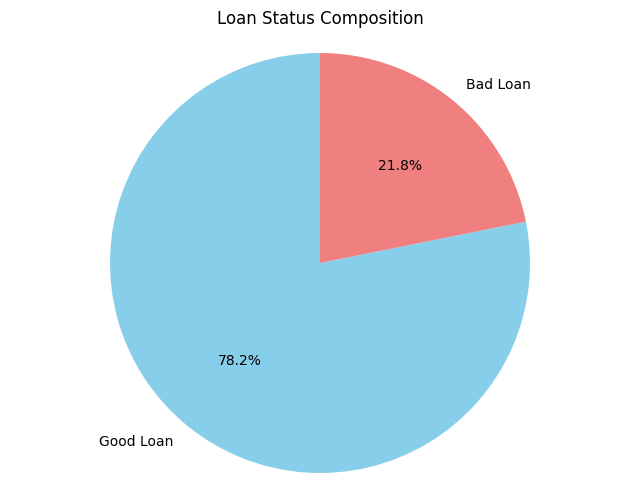

In [ ]:
loan_status_counts = data_handled_mv['loan_status'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.pie(loan_status_counts, labels=['Good Loan', 'Bad Loan'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Loan Status Composition')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

Our target variable is noticeably imbalanced, which may lead to model bias and impact the selection of evaluation metrics such as accuracy, precision, and F1-score. However, this imbalance can be addressed by applying undersampling or oversampling techniques before proceeding with the modeling phase, ensuring a more reliable and fair evaluation of the model’s performance.

## Q2: Who applies for credit the most frequently?

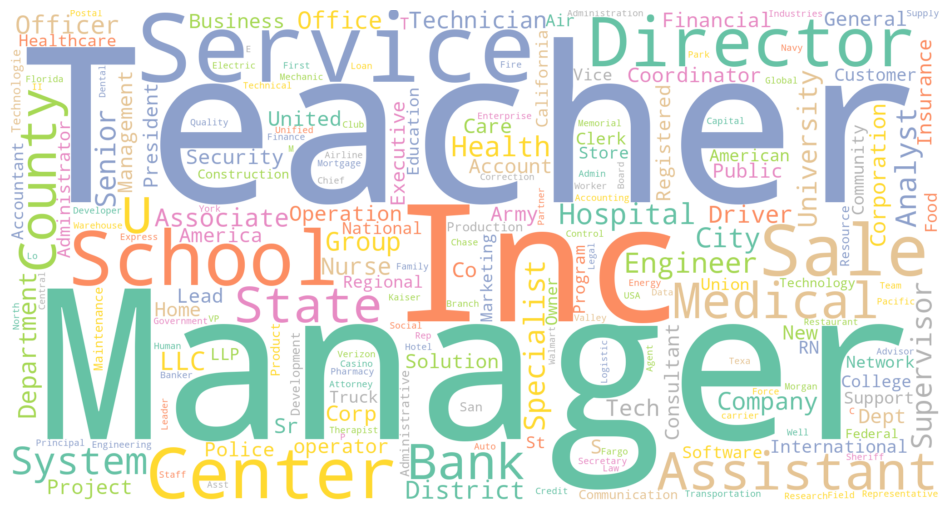

In [ ]:
title_loan = " ".join(str(tujuan) for tujuan in data_to_viz.emp_title)
word_cloud1 = WordCloud(collocations = False, background_color = 'white',
                        width = 2048, height = 1080, colormap='Set2').generate(title_loan)

plt.figure(figsize = (12, 12))
plt.imshow(word_cloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

## Q3: Which area has the highest concentration of borrowers?

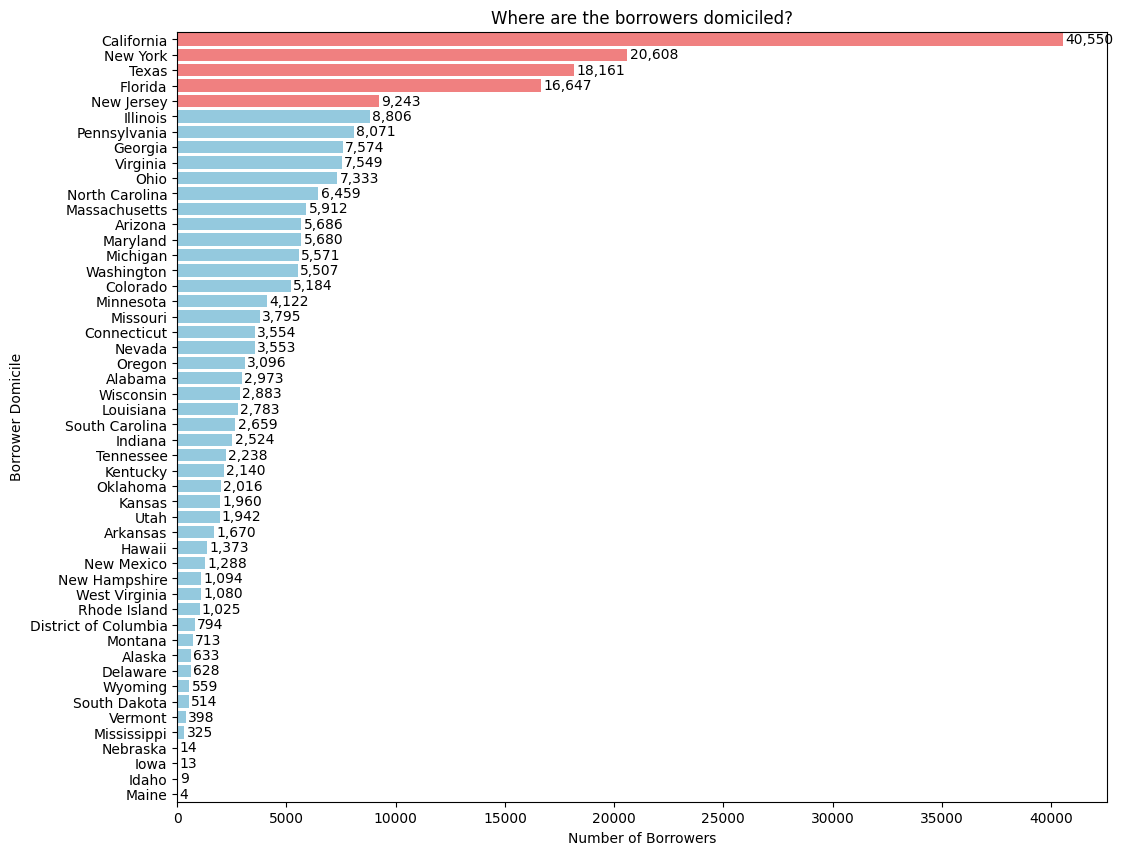

In [ ]:
state_mapping = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire',
    'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina',
    'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania',
    'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee',
    'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington',
    'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming',
'DC': 'District of Columbia', 'PR': 'Puerto Rico', 'VI': 'Virgin Islands'

}

# Apply the mapping to the 'addr_state' column
data_to_viz['addr_state_name'] = data_to_viz['addr_state'].map(state_mapping).fillna(data_to_viz['addr_state'])

# Count the occurrences of each state
state_counts = data_to_viz['addr_state_name'].value_counts().sort_values(ascending=False)

# Create a list of top 5 states
top_5_states = state_counts.head(5).index.tolist()

# Create the column chart
plt.figure(figsize=(12, 10))
ax = sns.countplot(y='addr_state_name', data=data_to_viz, order=state_counts.index, palette=["skyblue"] * len(state_counts))
plt.title("Where are the borrowers domiciled?")

# Highlight the top 5 states with a different color
for i, bar in enumerate(ax.patches):
    count = state_counts.iloc[i]  # Get the number of borrowers
    ax.text(
        bar.get_width() + 100,  # Position label slightly to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Center the text vertically
        f"{count:,}",  # Format with commas for better readability
        va='center', ha='left', fontsize=10, color='black'
    )
    if state_counts.index[i] in top_5_states:
        bar.set_facecolor('lightcoral')

# Customize the chart
plt.xlabel("Number of Borrowers")
plt.ylabel("Borrower Domicile")
plt.show()


## Q4: Which state has the highest risk of default?

<Figure size 1200x600 with 0 Axes>

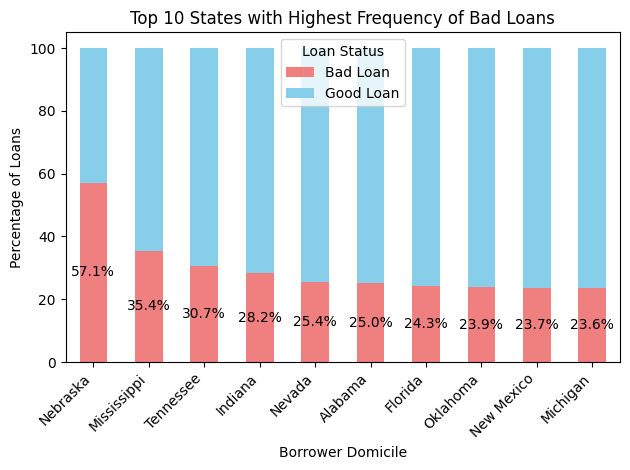

In [ ]:
# Calculate the percentage of bad loans for each state
bad_loan_percentages = data_to_viz.groupby('addr_state_name')['loan_status'].value_counts(normalize=True).unstack() * 100

# Select the top 10 states with the highest frequency of bad loans
top_10_states = bad_loan_percentages[0].nlargest(10).index

# Create the proportional stacked bar chart
plt.figure(figsize=(12, 6))
ax = bad_loan_percentages.loc[top_10_states, [0, 1]].plot(kind='bar', stacked=True, color=['lightcoral', 'skyblue'])

plt.title("Top 10 States with Highest Frequency of Bad Loans")
plt.xlabel("Borrower Domicile")
plt.ylabel("Percentage of Loans")
plt.legend(title="Loan Status", labels=["Bad Loan", "Good Loan"])
plt.xticks(rotation=45, ha='right')

# Add labels for bad loan percentage
for i, bar in enumerate(ax.patches):
    if i < len(top_10_states):  # Only label Bad Loan (bottom stack)
        height = bar.get_height()
        if height > 5:  # Only show label if the percentage is significant
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # Center horizontally
                bar.get_y() + height / 2,  # Position at middle of bad loan bar
                f"{height:.1f}%",  # Format as percentage with 1 decimal
                ha='center', va='center', fontsize=10, color='black'
            )

plt.tight_layout()
plt.show()

## Q5: Which loan term has a higher risk of becoming a bad loan?

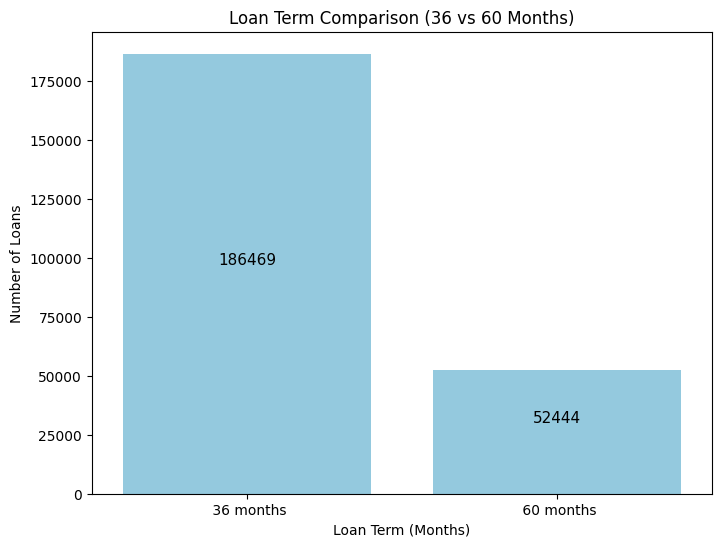

In [ ]:
term_counts = data_to_viz['term'].value_counts()

plt.figure(figsize=(8, 6))
ax = sns.countplot(x='term', data=data_to_viz, palette=['skyblue'])
plt.title('Loan Term Comparison (36 vs 60 Months)')
plt.xlabel('Loan Term (Months)')
plt.ylabel('Number of Loans')

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()/2),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.show()

<Figure size 1000x600 with 0 Axes>

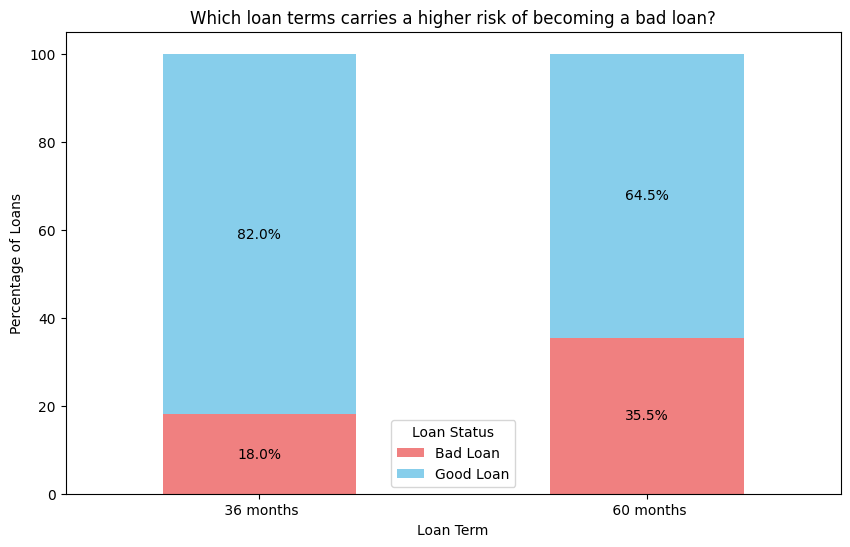

In [ ]:
plt.figure(figsize=(10, 6))

# Calculate the percentage for each loan_status within each term
loan_status_percentage = data_to_viz.groupby(['term', 'loan_status']).size().unstack().fillna(0)
loan_status_percentage = loan_status_percentage.div(loan_status_percentage.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart
ax = loan_status_percentage.plot(kind='bar', stacked=True, color=['lightcoral', 'skyblue'], figsize=(10, 6))

# Set titles and labels
plt.title('Which loan terms carries a higher risk of becoming a bad loan?')
plt.xlabel('Loan Term')
plt.ylabel('Percentage of Loans')
plt.xticks(rotation=0)
plt.legend(title='Loan Status', labels=['Bad Loan', 'Good Loan'])

# Annotate the bars with the percentage at the center of each section
for bars in ax.containers:
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Only annotate non-zero sections
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # Center horizontally
                bar.get_y() + height / 2,  # Center vertically
                f'{height:.1f}%',
                ha='center', va='center', color='black', fontsize=10
            )

plt.show()

## Q6: How does the loan purpose affect the bad loan rate?

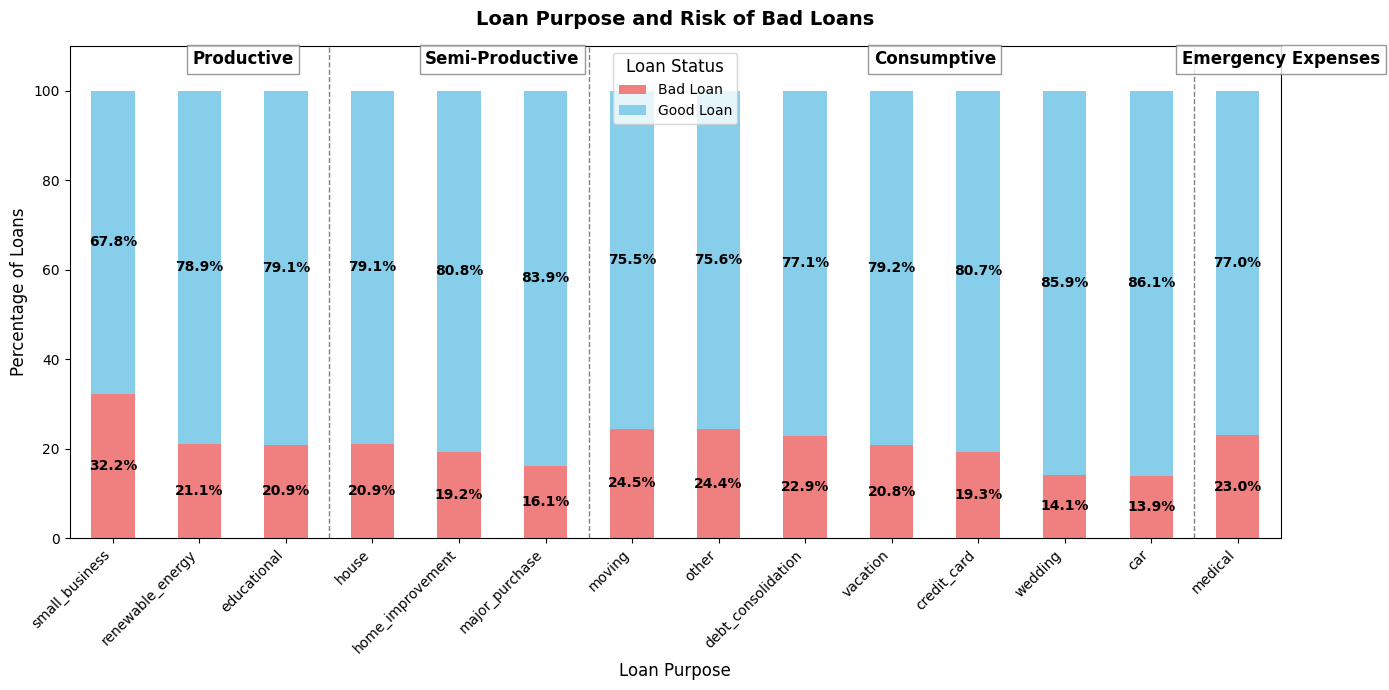

In [ ]:
# Kategorisasi loan purpose berdasarkan produktivitas dan risiko
category_order = {
    'Productive': ['small_business', 'educational', 'renewable_energy'],
    'Semi-Productive': ['house', 'major_purchase', 'home_improvement'],
    'Consumptive': ['moving', 'wedding', 'vacation', 'other', 'car', 'debt_consolidation', 'credit_card'],
    'Emergency Expenses': ['medical']
}

# Menentukan urutan berdasarkan kategori
ordered_purpose = sum(category_order.values(), [])  # Flatten list
purpose_loan_status = data_to_viz.groupby('purpose')['loan_status'].value_counts(normalize=True).unstack() * 100

# Sorting berdasarkan bad loan rate, tetapi tetap mempertahankan urutan kategori
sorted_purpose = []
for category, purposes in category_order.items():
    sub_df = purpose_loan_status.loc[purposes].sort_values(0, ascending=False)  # Sort bad loan rate descending
    sorted_purpose.append(sub_df)

# Gabungkan hasil sorting tanpa mengubah urutan kategori utama
purpose_loan_status_sorted = pd.concat(sorted_purpose)

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
purpose_loan_status_sorted[[0, 1]].plot(kind='bar', stacked=True, color=['lightcoral', 'skyblue'], ax=ax)

# Title & Labels
plt.title('Loan Purpose and Risk of Bad Loans', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Loan Purpose', fontsize=12)
plt.ylabel('Percentage of Loans', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Loan Status', labels=['Bad Loan', 'Good Loan'], fontsize=10, title_fontsize=12)

# Annotate with percentages inside bars
for bars in ax.containers:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            text_color = 'white' if bar.get_facecolor() == (1.0, 0.4, 0.4, 1.0) else 'black'  # Adjust color
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f'{height:.1f}%',
                ha='center', va='center', color=text_color, fontsize=10, fontweight='bold'
            )

# Tambahkan garis pemisah kategori & label di atas chart
x_pos = 0
category_positions = []
for category, purposes in category_order.items():
    x_pos += len(purposes)
    if x_pos < len(ordered_purpose):
        ax.axvline(x=x_pos - 0.5, color='gray', linestyle='--', lw=1)
    category_positions.append((x_pos - len(purposes) / 2, category))  # Perbaiki posisi label

# Tambahkan label kategori di atas chart
for pos, category in category_positions:
    ax.text(pos, 105, category, ha='center', va='bottom', fontsize=12, fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

plt.ylim(0, 110)  # Beri ruang untuk label kategori
plt.tight_layout()
plt.show()


1. Productive, A Hidden Risk Behind Productive Borrowing

Small business loans have the highest bad loan rate (32.2%) among productive loans, likely due to unstable cash flows, market volatility, and financial management challenges. Unlike educational or renewable energy loans, small businesses face higher risks of default, especially during economic downturns. Strengthening credit screening, offering financial literacy programs, and implementing flexible repayment plans can help mitigate these risks while still supporting small business growth.

2. Semi-Productive.

Not the Riskiest, But Not Risk-Free

Semi-productive loans show a relatively balanced risk, hovering around the average bad loan rate of 21.8%. House (20.95%) and home improvement (19.23%) loans carry moderate risk, likely due to their long-term financial commitments. Meanwhile, major purchases (16.10%) have the lowest risk in this category, possibly because of smaller loan amounts and shorter repayment periods. While no single loan type dominates in risk, careful monitoring is needed to ensure borrowers can sustain their repayments over time.

3. Consumptive

Consumptive loans exhibit a wider range of risks, with certain categories exceeding the 21.8% bad loan rate. Moving (24.47%) and other loans (24.36%) stand out with the highest default rates in this category, likely due to their discretionary nature and less predictable repayment behavior. Debt consolidation (22.89%) also carries notable risk, possibly due to borrowers’ prior financial struggles. On the other hand, wedding (14.13%) and car loans (13.92%) show relatively lower risks, as these are often well-planned expenses with clearer repayment timelines. Overall, while consumptive loans present higher risks, there are still areas with stable performance.

another analysis:
While consumptive loans are often perceived as highly risky, the data reveals a clear divide between high-risk and low-risk loan types. Moving expenses (24.47%) and debt consolidation (22.88%) have the highest default rates, likely due to their unplanned nature and borrowers already experiencing financial distress. These loans often do not generate financial returns, making repayment more difficult. On the other hand, vacation (20.77%) and credit card (19.31%) loans, while still consumptive, show moderate risk, suggesting that borrowers taking these loans may still have some level of financial control. Surprisingly, car (13.92%) and wedding (14.13%) loans carry the lowest risk, possibly because cars provide functional value and missed payments can result in repossession, while weddings are usually planned well in advance with structured financial commitments. This variation highlights that not all consumptive loans should be treated equally—some require stricter risk management, while others may be more stable than expected. Understanding borrower behavior and financial habits is crucial in assessing the real risk behind each loan purpose.

4. Emergency Expense

A Financial Dilemma

Medical loans have a bad loan rate of 22.99%, slightly above the overall average. While healthcare costs are often unavoidable, the high default rate suggests that many borrowers struggle with repayment after covering medical emergencies. Unlike other loans, medical expenses are typically unplanned and urgent, leaving borrowers with limited financial flexibility. This highlights the need for better financial planning options, such as insurance or structured repayment assistance, to reduce the burden on borrowers facing unexpected health crises.

# Feature Engineering and Selection

In [ ]:
df1 = data_to_viz.copy()

Column emp_lenght

In [ ]:
# unique value dari emp_length
df1['emp_length'].unique()

array(['10+ years', '< 1 year', '3 years', '9 years', '4 years',
       '5 years', '1 year', '6 years', '2 years', '7 years', '8 years'],
      dtype=object)

In [ ]:
# Mengubah ke bentuk numerik
df1['emp_length_num'] = df1['emp_length'].str.extract(r'(\d+)').astype(float)
print(df1['emp_length_num'].unique())

[10.  1.  3.  9.  4.  5.  6.  2.  7.  8.]


In [ ]:
#drop emp_length
df1.drop('emp_length', axis=1, inplace=True)

- Column term

In [ ]:
# print values dari ['term']
df1['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [ ]:
# menghapus teks pada 'term' dan menyisakan hanya angka
df1['term_int'] = df1['term'].str.replace(' months', '').astype(int)
print(df1['term_int'].unique())

[36 60]


In [ ]:

# drop 'term'
df1.drop('term', axis=1, inplace=True)

- Date column

## Check Correlation

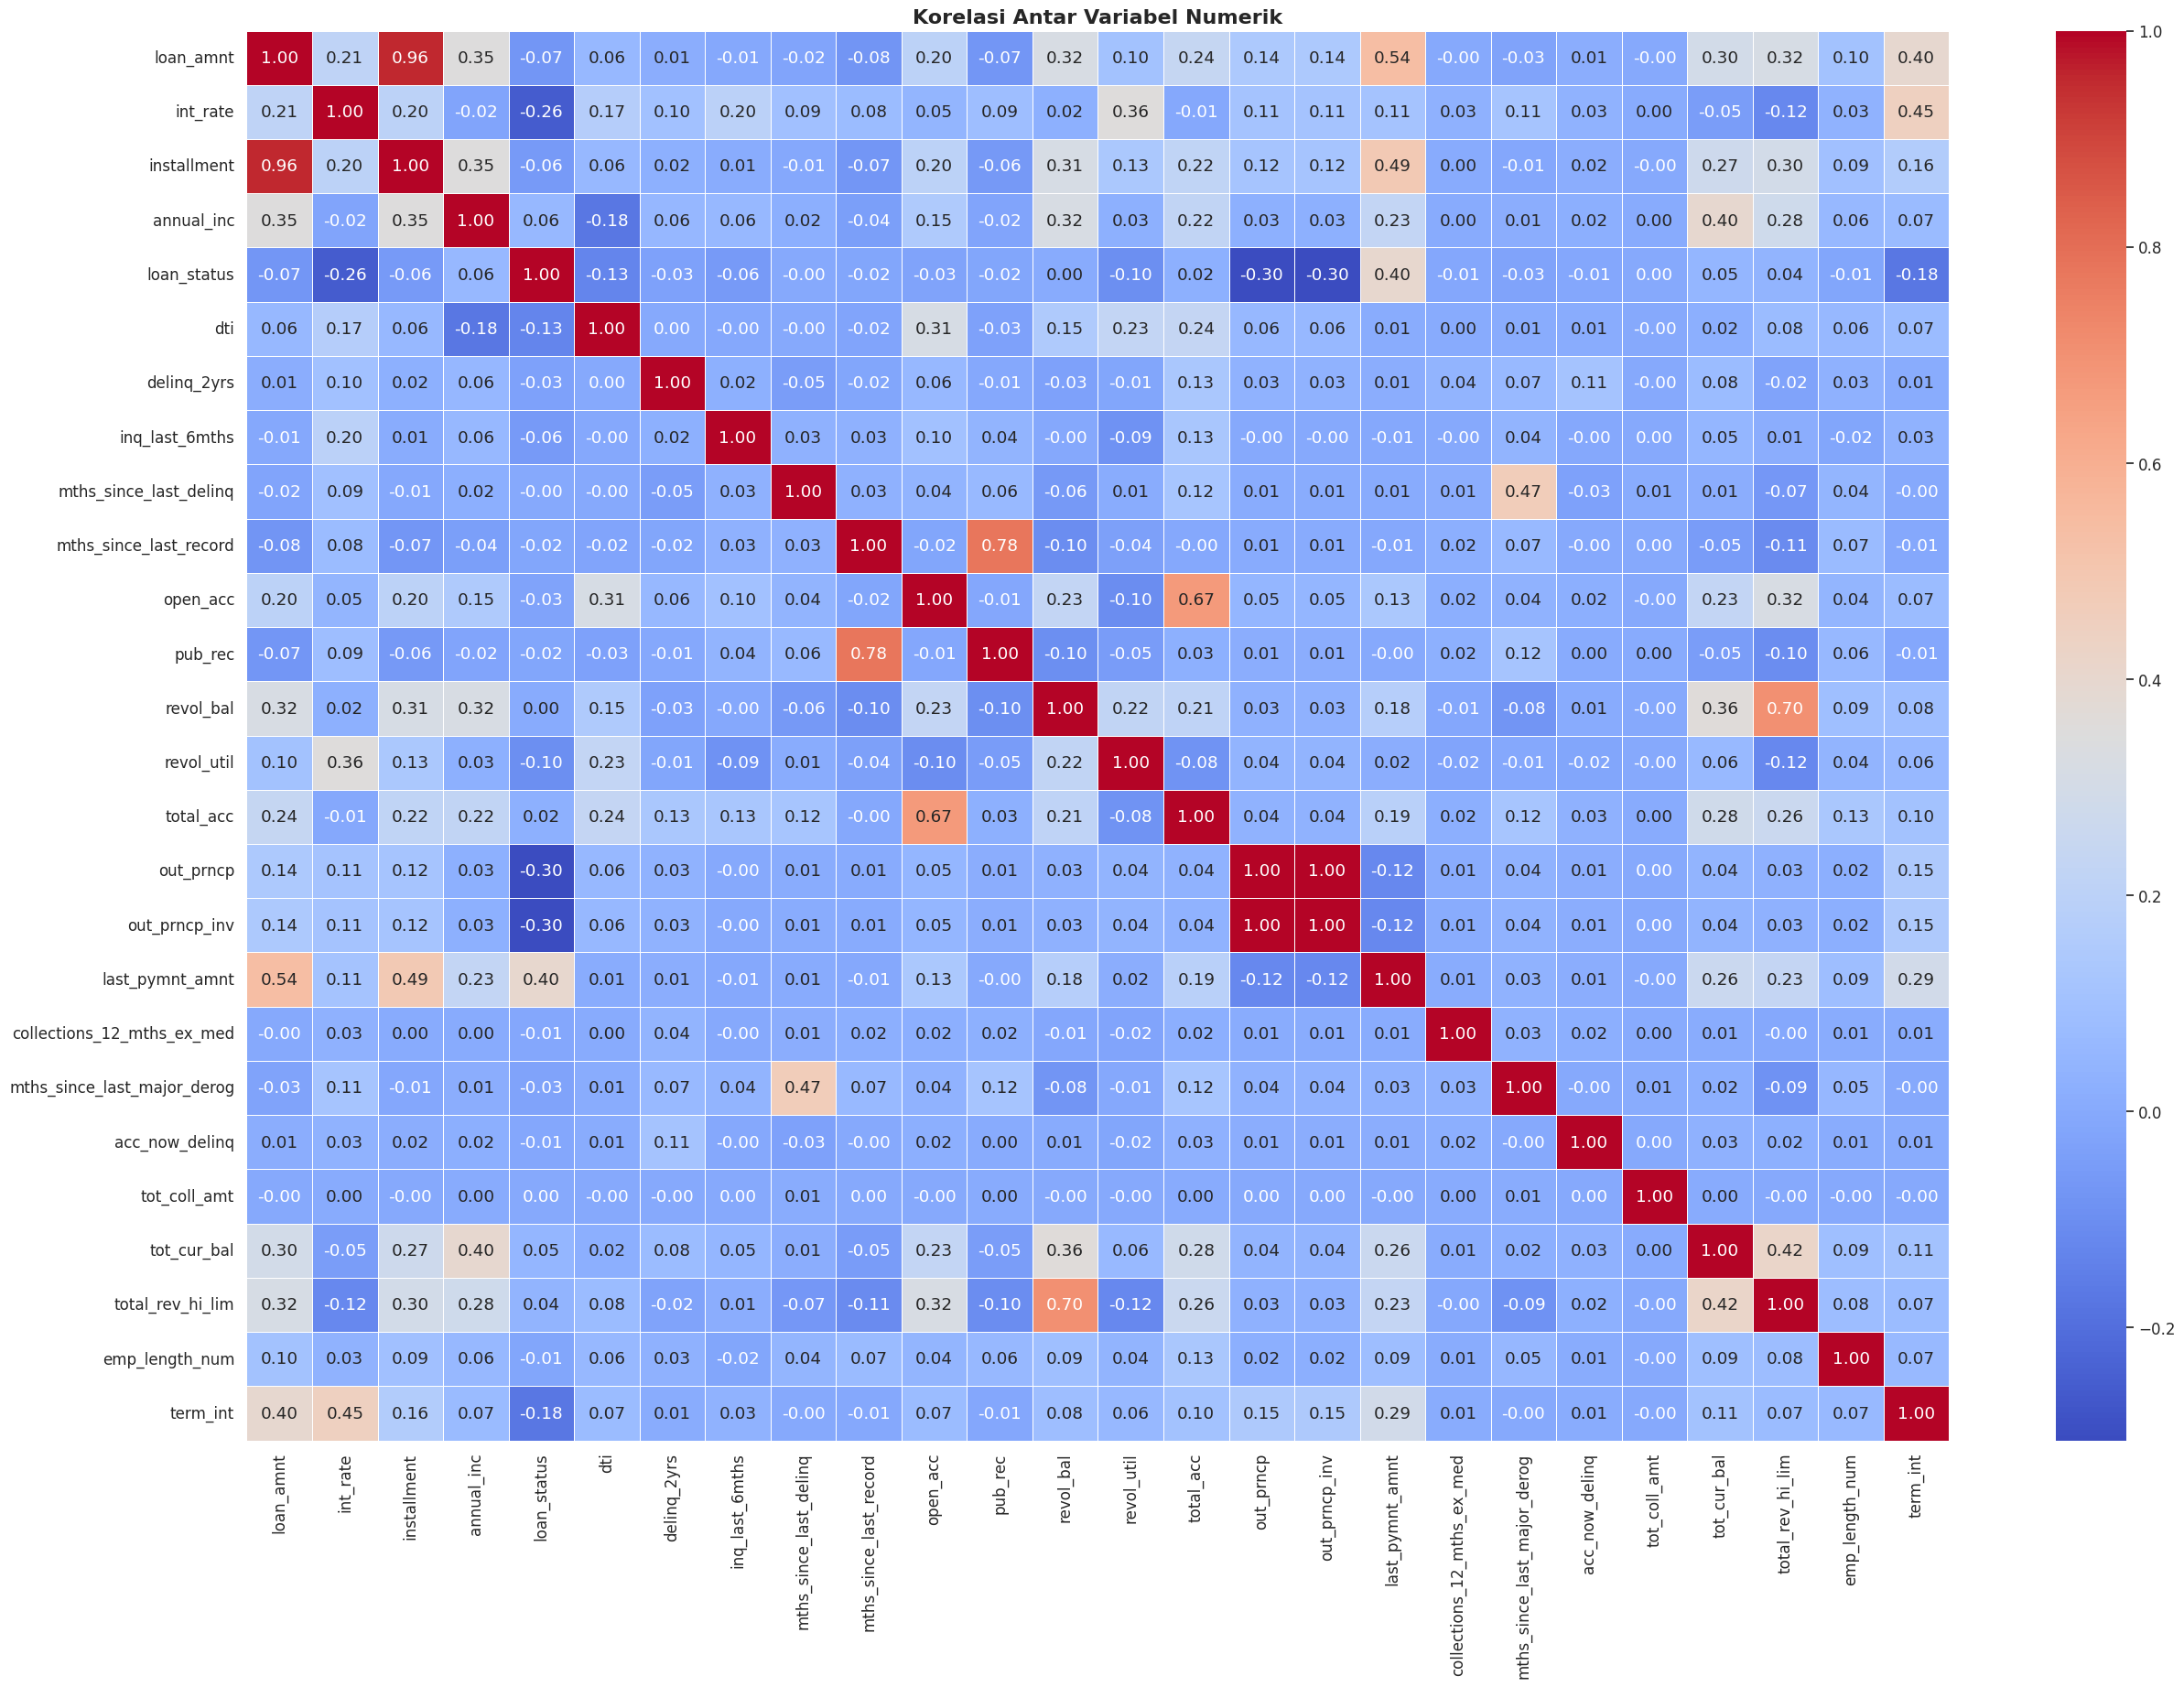

In [ ]:
num_data = df1.select_dtypes(include=['number'])
corr_matrix = num_data.corr()

# Plot Heatmap
plt.figure(figsize=(30, 20))
sns.set(font_scale=1.1)
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Korelasi Antar Variabel Numerik", fontsize=16, weight='bold')
plt.show()

## Encoding the Categorical Data

In [ ]:
categorical_cols = [col for col in df1.select_dtypes(include='object').columns.tolist()if col not in ['bad_flag']]
categorical_cols

['emp_title',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'addr_state_name']

In [ ]:
df1.drop(['emp_title','addr_state_name'], axis=1, inplace=True)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 238913 entries, 0 to 466283
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    238913 non-null  int64  
 1   int_rate                     238913 non-null  float64
 2   installment                  238913 non-null  float64
 3   home_ownership               238913 non-null  object 
 4   annual_inc                   238913 non-null  float64
 5   verification_status          238913 non-null  object 
 6   loan_status                  238913 non-null  int64  
 7   pymnt_plan                   238913 non-null  object 
 8   purpose                      238913 non-null  object 
 9   addr_state                   238913 non-null  object 
 10  dti                          238913 non-null  float64
 11  delinq_2yrs                  238913 non-null  float64
 12  earliest_cr_line             238913 non-null  object 
 13  inq_

In [ ]:
numerical_cols = [col for col in df1.select_dtypes(include=np.number).columns.tolist() if col not in ['bad_flag']]
numerical_cols

['loan_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'loan_status',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'last_pymnt_amnt',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'emp_length_num',
 'term_int']

In [ ]:
df1['earliest_cr_line'] = pd.to_datetime(df1['earliest_cr_line'], errors='coerce')

reference_date = pd.to_datetime('2017-12-01')

# Hitung jumlah bulan sejak 'earliest_cr_line' hingga reference_date
df1['months_since_earliest_cr_line'] = (reference_date.year - df1['earliest_cr_line'].dt.year) * 12 + (reference_date.month - df1['earliest_cr_line'].dt.month)

# Tampilkan hasil beberapa baris pertama
print(df1[['earliest_cr_line', 'months_since_earliest_cr_line']].head())

  earliest_cr_line  months_since_earliest_cr_line
0       1985-01-01                            395
1       1999-04-01                            224
2       2001-11-01                            193
3       1996-02-01                            262
5       2004-11-01                            157


In [ ]:
df1.drop('earliest_cr_line', axis = 1, inplace = True)

In [ ]:
label_encoder = LabelEncoder()

df1['home_ownership']= label_encoder.fit_transform(df1['home_ownership'])
df1['verification_status']= label_encoder.fit_transform(df1['verification_status'])
df1['purpose']= label_encoder.fit_transform(df1['purpose'])
df1['addr_state']= label_encoder.fit_transform(df1['addr_state'])
df1['initial_list_status']= label_encoder.fit_transform(df1['initial_list_status'])
df1['pymnt_plan']= label_encoder.fit_transform(df1['pymnt_plan'])

In [ ]:
categorical_cols = [col for col in df1.select_dtypes(include='object').columns.tolist()if col not in ['bad_flag']]
categorical_cols

[]

## Splitting Data

In [ ]:
df2 = df1.copy()
X = df2.drop(columns="loan_status")
y = df2.loan_status

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((191130, 32), (47783, 32), (191130,), (47783,))

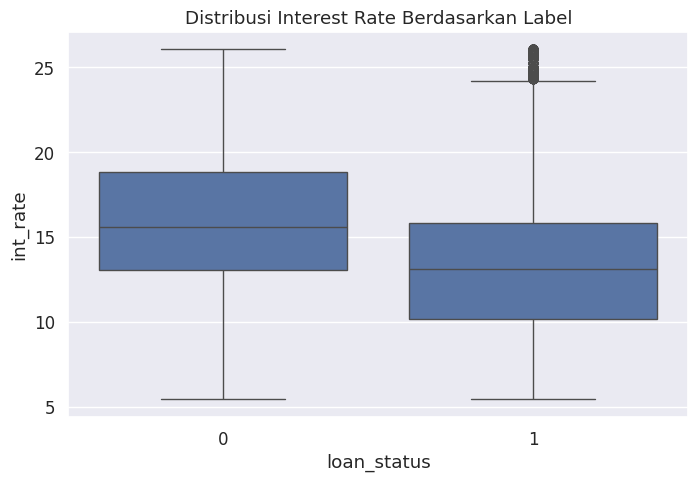

In [ ]:
# Cek distribusi interest rate berdasarkan label
plt.figure(figsize=(8, 5))
sns.boxplot(x=y_train, y=X_train["int_rate"])
plt.title("Distribusi Interest Rate Berdasarkan Label")
plt.show()

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(191130, 32)
(47783, 32)


# Modelling Baseline

In [ ]:
# Model Logistic Regression dengan L2 Regularization (Ridge)

lr = LogisticRegression(class_weight='balanced', penalty='l2', solver='liblinear', random_state=42)
lr.fit(X_train_scaled, y_train)
Y_pred = lr.predict(X_test_scaled)
print("=== Classification Report (Logistic Regression Ridge without PCA/SelectKBest) ===")
print(classification_report(y_test, Y_pred))

=== Classification Report (Logistic Regression Ridge without PCA/SelectKBest) ===
              precision    recall  f1-score   support

           0       0.61      0.94      0.74     10437
           1       0.98      0.83      0.90     37346

    accuracy                           0.86     47783
   macro avg       0.80      0.89      0.82     47783
weighted avg       0.90      0.86      0.86     47783



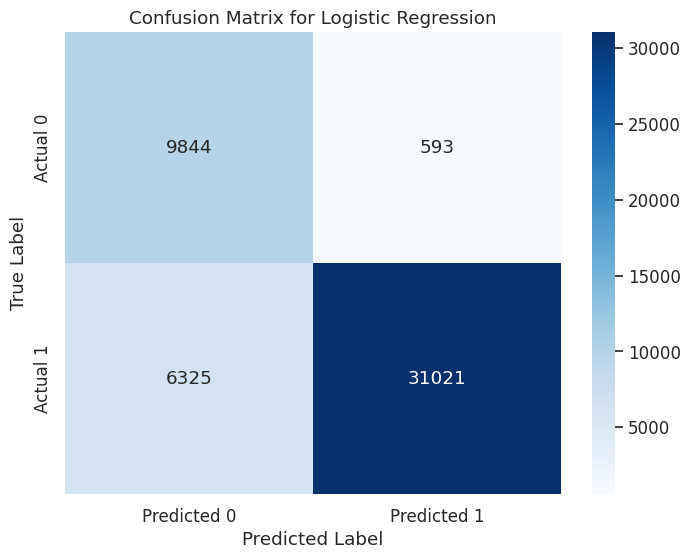

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, Y_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [ ]:
# Model XGBoost dengan L1 dan L2 Regularization

xgb = XGBClassifier(
    scale_pos_weight=(sum(y_train == 0) / sum(y_train == 1)),  # Menangani ketidakseimbangan
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=0.5,  # L2 regularization
    random_state=42
)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)
print("=== Classification Report (XGBoost) ===")
print(classification_report(y_test, y_pred_xgb))

=== Classification Report (XGBoost) ===
              precision    recall  f1-score   support

           0       0.71      0.93      0.81     10437
           1       0.98      0.89      0.93     37346

    accuracy                           0.90     47783
   macro avg       0.84      0.91      0.87     47783
weighted avg       0.92      0.90      0.91     47783



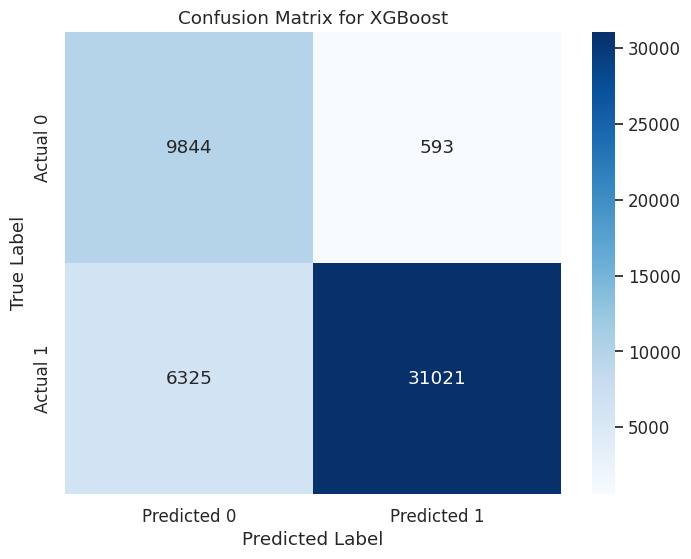

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, Y_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for XGBoost')
plt.show()

In [ ]:
# Model Decision Tree

decision_tree = DecisionTreeClassifier(max_depth=4)
decision_tree.fit(X_train_scaled, y_train)
Y_pred = decision_tree.predict(X_test_scaled)

print("=== Classification Report (Decision Tree) ===")
print(classification_report(y_test, Y_pred))

=== Classification Report (Decision Tree) ===
              precision    recall  f1-score   support

           0       0.91      0.45      0.60     10437
           1       0.87      0.99      0.92     37346

    accuracy                           0.87     47783
   macro avg       0.89      0.72      0.76     47783
weighted avg       0.87      0.87      0.85     47783



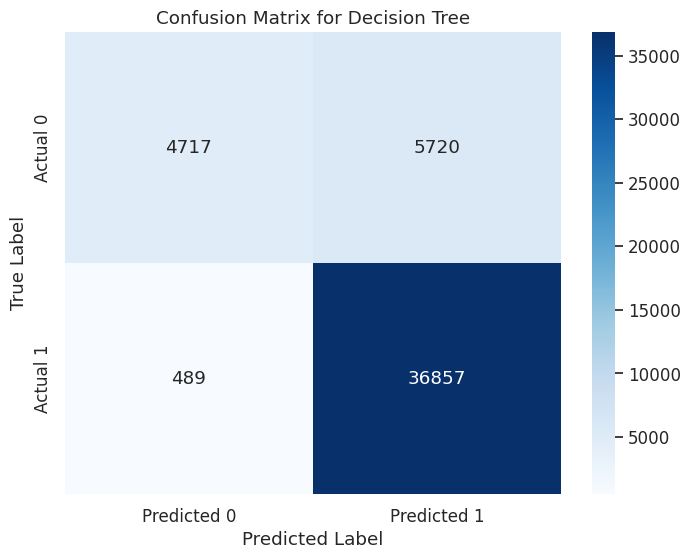

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, Y_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

In [ ]:
# Model Random Forest

rf = RandomForestClassifier(class_weight="balanced", random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
print("=== Classification Report (Random Forest) ===")
print(classification_report(y_test, y_pred_rf))

=== Classification Report (Random Forest) ===
              precision    recall  f1-score   support

           0       0.84      0.75      0.79     10437
           1       0.93      0.96      0.95     37346

    accuracy                           0.91     47783
   macro avg       0.89      0.85      0.87     47783
weighted avg       0.91      0.91      0.91     47783



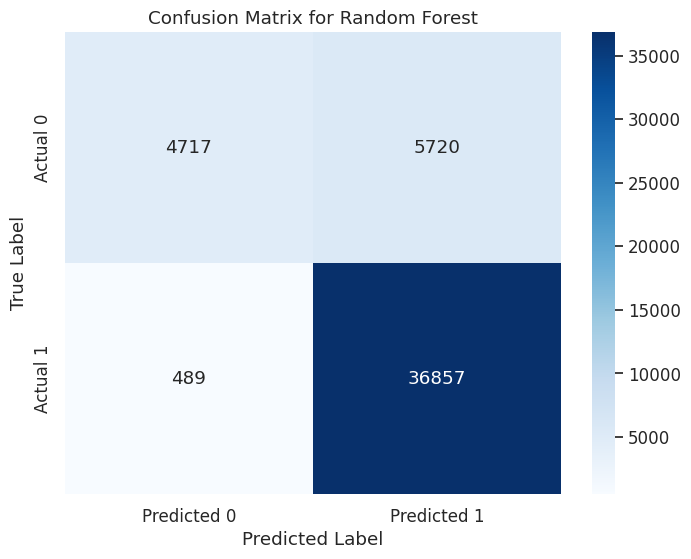

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, Y_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest')
plt.show()

# Modelling and Evaluation with SelectKBest Features = 10

In [ ]:
# SelectKBest untuk memilih fitur terbaik
selector = SelectKBest(f_classif, k=10)  # Pilih 10 fitur terbaik
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [ ]:
lrs = LogisticRegression(class_weight='balanced', penalty='l2', solver='liblinear', random_state=42)
lrs.fit(X_train_selected, y_train)
Y_pred = lrs.predict(X_test_selected)
print("=== Classification Report (Logistic Regression Ridge with SelectKBest) ===")
print(classification_report(y_test, Y_pred))

=== Classification Report (Logistic Regression Ridge with SelectKBest) ===
              precision    recall  f1-score   support

           0       0.59      0.95      0.73     10437
           1       0.98      0.82      0.89     37346

    accuracy                           0.85     47783
   macro avg       0.79      0.88      0.81     47783
weighted avg       0.90      0.85      0.86     47783



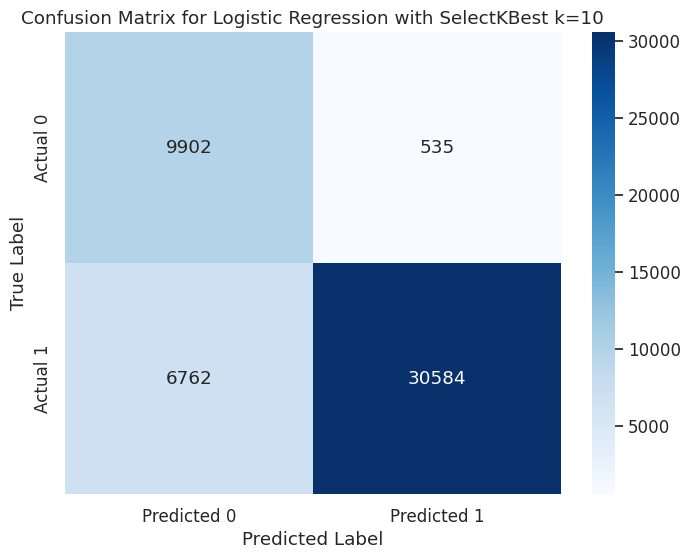

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, Y_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression with SelectKBest k=10')
plt.show()

In [ ]:
# Model XGBoost dengan L1 dan L2 Regularization

xgb = XGBClassifier(
    scale_pos_weight=(sum(y_train == 0) / sum(y_train == 1)),  # Menangani ketidakseimbangan
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=0.5,  # L2 regularization
    random_state=42
)
xgb.fit(X_train_selected, y_train)
y_pred_xgb = xgb.predict(X_test_selected)
print("=== Classification Report (XGBoost) with SelectKBest k = 10 ===")
print(classification_report(y_test, y_pred_xgb))

=== Classification Report (XGBoost) with SelectKBest k = 10 ===
              precision    recall  f1-score   support

           0       0.67      0.95      0.78     10437
           1       0.98      0.87      0.92     37346

    accuracy                           0.89     47783
   macro avg       0.83      0.91      0.85     47783
weighted avg       0.91      0.89      0.89     47783



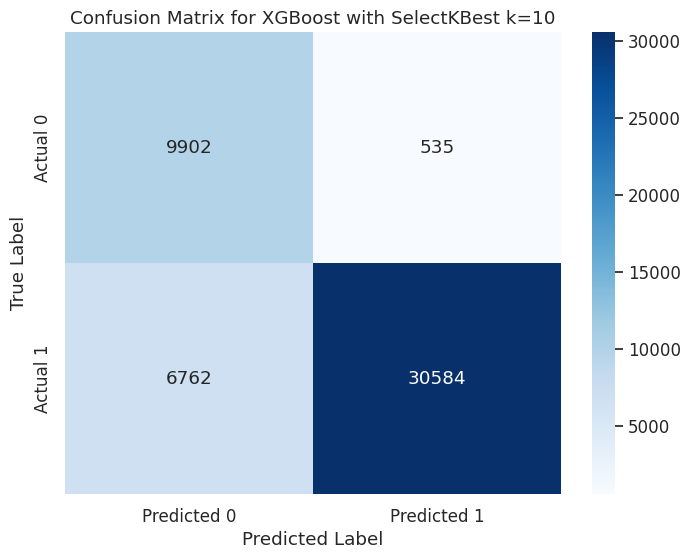

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, Y_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for XGBoost with SelectKBest k=10')
plt.show()

In [ ]:
# Model Decision Tree

decision_tree = DecisionTreeClassifier(max_depth=4)
decision_tree.fit(X_train_selected, y_train)
Y_pred = decision_tree.predict(X_test_selected)

print("=== Classification Report (Decision Tree with SelectKBest k=10) ===")
print(classification_report(y_test, Y_pred))

=== Classification Report (Decision Tree with SelectKBest k=10) ===
              precision    recall  f1-score   support

           0       0.90      0.45      0.60     10437
           1       0.87      0.99      0.92     37346

    accuracy                           0.87     47783
   macro avg       0.88      0.72      0.76     47783
weighted avg       0.87      0.87      0.85     47783



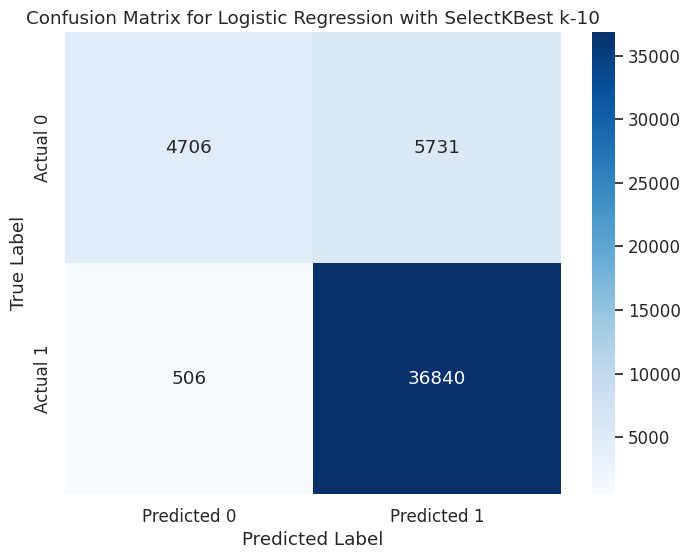

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, Y_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression with SelectKBest k-10')
plt.show()

In [ ]:
# Model Random Forest

rf = RandomForestClassifier(class_weight="balanced", random_state=42)
rf.fit(X_train_selected, y_train)
y_pred_rf = rf.predict(X_test_selected)
print("=== Classification Report (Random Forest) with SelectKBest k=10 ===")
print(classification_report(y_test, y_pred_rf))

=== Classification Report (Random Forest) with SelectKBest k=10 ===
              precision    recall  f1-score   support

           0       0.83      0.75      0.79     10437
           1       0.93      0.96      0.94     37346

    accuracy                           0.91     47783
   macro avg       0.88      0.85      0.87     47783
weighted avg       0.91      0.91      0.91     47783



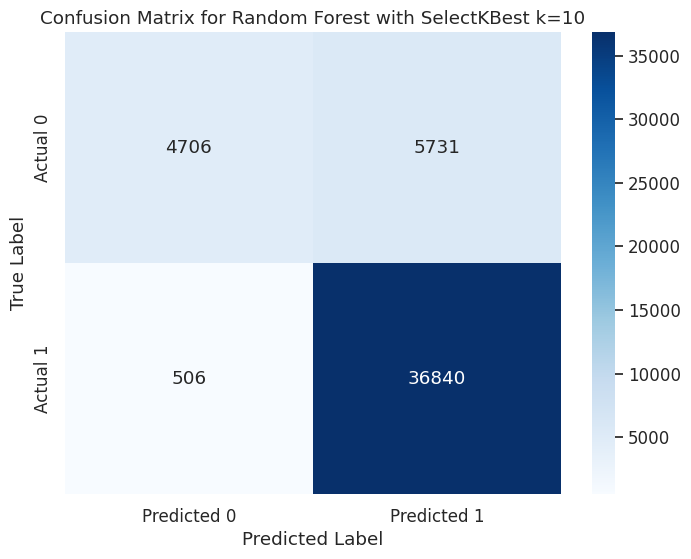

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, Y_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest with SelectKBest k=10')
plt.show()

In [ ]:
y_pred_proba = rf.predict_proba(X_test_selected)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

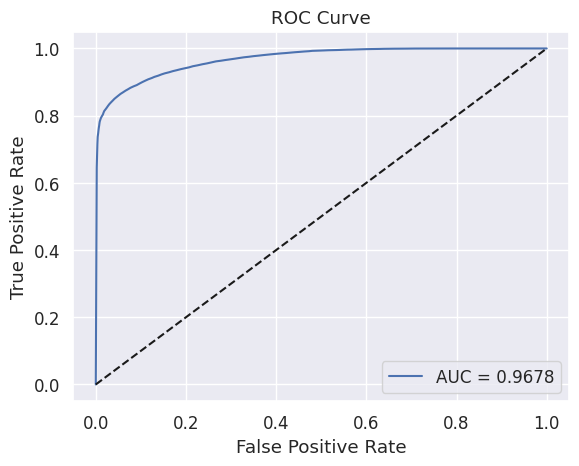

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()